In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fear = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

print("Fear/Greed columns:", list(fear.columns))
print("Trades columns:", list(trades.columns))
print("\nFear/Greed sample:")
print(fear.head())
print("\nTrades sample:")
print(trades.head())

Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Fear/Greed sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trades sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b911

/tmp/ipython-input-3210374824.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("/content/historical_data.csv")


In [4]:
# ---------- CONFIG ----------
TOLERANCE_DAYS = 2                        # change to 1, 2, 5 etc.

# 2) Parse / normalize datetime columns
fear['fear_date'] = pd.to_datetime(fear['date'], errors='coerce')

# First try explicit format
trades['trade_date'] = pd.to_datetime(
    trades.get('Timestamp IST', trades.get('timestamp_ist', None)),
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)

# If parsing failed, try generic parsing
if trades['trade_date'].isna().any():
    trades['trade_date'] = trades['trade_date'].fillna(
        pd.to_datetime(
            trades.get('Timestamp IST', trades.get('timestamp_ist', None)),
            errors='coerce',
            dayfirst=True
        )
    )

# 3) Sort (required for merge_asof)
fear = fear.sort_values('fear_date').reset_index(drop=True)
trades = trades.sort_values('trade_date').reset_index(drop=True)

# 4) Prepare right-side fear columns
fear_right = fear[['fear_date'] + [c for c in ['value','classification'] if c in fear.columns]]

# 5) Nearest-date merge
merged = pd.merge_asof(
    left=trades,
    right=fear_right,
    left_on='trade_date',
    right_on='fear_date',
    direction='nearest',
    tolerance=pd.Timedelta(days=TOLERANCE_DAYS)
)

# 6) Calculate date difference
merged['date_diff_days'] = (merged['trade_date'] - merged['fear_date']).dt.days

# 7) Summary
total_trades = len(merged)
matched = merged['fear_date'].notna().sum()
unmatched = total_trades - matched

print(f"Total trades: {total_trades}")
print(f"Matched (±{TOLERANCE_DAYS} days): {matched}")
print(f"Unmatched: {unmatched}")

# Distribution of differences
print("\nDate difference distribution (days):")
print(merged['date_diff_days'].value_counts(dropna=True).sort_index())

# 8) Trades matched within 1 day (optional)
within_1day = merged[merged['date_diff_days'].abs() <= 1]
print(f"Trades matched within 1 day: {len(within_1day)}")

# 9) Unmatched rows (optional sample)
unmatched_rows = merged[merged['fear_date'].isna()]
if len(unmatched_rows) > 0:
    print("\nSample unmatched:")
    cols = ['trade_date', 'date_diff_days']
    print(unmatched_rows.head()[cols])


Total trades: 69811
Matched (±2 days): 69811
Unmatched: 0

Date difference distribution (days):
date_diff_days
-1    30760
 0    39051
Name: count, dtype: int64
Trades matched within 1 day: 69811


i tried see how much difference is there between the fear and trader dataset dates and mostly it exact same day or next day

In [5]:
from IPython.display import display

# Ensure 'merged' exists
if 'merged' not in globals():
    raise NameError("No merged dataframe found. Run the merge code first so `merged` exists.")

df = merged.copy()

In [6]:
print("MERGED shape:", df.shape)
display(df.head(10))
print("\nColumn summary:")
display(pd.Series(df.columns))

MERGED shape: (69811, 21)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,fear_date,value,classification,date_diff_days
0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.86810,1935.95,BUY,05-12-2023 03:11,0.4933,Open Long,0.000000,...,4064960965,True,0.483987,2.340000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
1,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.25000,557.52,BUY,05-12-2023 03:11,1.3614,Open Long,0.000000,...,4064960965,True,0.139381,2.580000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
2,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,3.37330,7522.80,BUY,05-12-2023 03:11,1.6114,Open Long,0.000000,...,4064960965,True,1.880699,8.740000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
3,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,1.88560,4205.08,BUY,05-12-2023 03:11,4.9847,Open Long,0.000000,...,4064960965,True,1.051269,1.020000e+15,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.2,0.44840,1000.02,BUY,05-12-2023 03:11,6.8703,Open Long,0.000000,...,4064960965,True,0.250005,2.920000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
5,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2231.0,3.89320,8685.73,BUY,05-12-2023 03:11,7.3187,Open Long,0.000000,...,4064960965,True,2.171432,1.060000e+15,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
6,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41867.0,0.01500,628.00,SELL,05-12-2023 03:11,0.0000,Open Short,0.000000,...,4064974623,True,0.157001,1.070000e+15,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
7,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41866.0,0.58211,24370.62,SELL,05-12-2023 03:11,-0.0150,Open Short,0.000000,...,4064974623,True,6.092654,2.830000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
8,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.49330,1100.11,BUY,05-12-2023 03:11,0.0000,Open Long,0.000000,...,4064960965,True,0.275027,6.320000e+14,1.700000e+12,2023-12-05 03:11:00,2023-12-05,75,Extreme Greed,0
9,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2252.3,11.21190,25252.56,SELL,14-12-2023 01:20,11.2119,Close Long,245.428491,...,4626057386,True,6.313140,6.790000e+14,1.700000e+12,2023-12-14 01:20:00,2023-12-14,72,Greed,0



Column summary:


,0
0,Account
1,Coin
2,Execution Price
3,Size Tokens
4,Size USD
5,Side
6,Timestamp IST
7,Start Position
8,Direction
9,Closed PnL


In [7]:
# Normalize / ensure trade datetime exists
# Prefer 'trade_date' (from your merge), else try common alternatives
dt_candidates = ['trade_date', 'trade_dt', 'datetime_ist', 'datetime', 'timestamp_dt', 'timestamp']
for c in dt_candidates:
    if c in df.columns:
        df['trade_dt'] = pd.to_datetime(df[c], errors='coerce')
        # keep the first candidate that yields at least one non-null
        if df['trade_dt'].notna().any():
            break

# Fallback: if no trade_dt yet, try any column that looks like a date
if 'trade_dt' not in df.columns or df['trade_dt'].isna().all():
    for c in df.columns:
        if df[c].dtype == object and df[c].astype(str).str.contains(r'\d{4}|\d{2}-\d{2}-\d{4}', na=False).any():
            df['trade_dt'] = pd.to_datetime(df[c], errors='coerce')
            if df['trade_dt'].notna().any():
                break

# Create normalized day column for aggregations
df['trade_day'] = df['trade_dt'].dt.normalize()

In [8]:
# Identify columns to drop (automated, conservative)
cols_to_drop = set()

# A: Extremely sparse columns (>85% missing)
na_ratio = df.isna().mean()
cols_to_drop.update(na_ratio[na_ratio > 0.85].index.tolist())

# B: Single-value columns (no signal)
cols_to_drop.update([c for c in df.columns if df[c].nunique(dropna=False) <= 1])

# C: Hash/ID-like columns — mostly-unique long strings
for c in df.select_dtypes(include=['object']).columns:
    nunq = df[c].nunique(dropna=False)
    prop_unique = nunq / max(1, len(df))
    avg_len = df[c].dropna().astype(str).map(len).mean() if df[c].notna().any() else 0
    if prop_unique > 0.95 and avg_len > 20:
        cols_to_drop.add(c)

# D: Name-based heuristics for obvious technical columns
name_patterns = ['transaction_hash','tx_hash','txid','transaction','token_id','wallet','wallet_address',
                 'signature','raw_tx','row','index','payload','meta','json']
for pat in name_patterns:
    for c in df.columns:
        if pat in c.lower():
            cols_to_drop.add(c)

# Keep a safe list even if they matched a drop rule
safe_keep = {'trade_id', 'order_id', 'account', 'coin', 'execution_price',
             'size_tokens', 'size_usd', 'closed_pnl', 'fee', 'side', 'direction',
             'sentiment', 'value', 'fear_date', 'trade_dt', 'trade_day'}
cols_to_drop = [c for c in cols_to_drop if c in df.columns and c not in safe_keep]

# Show what will be dropped (first 30 for readability)
print("\nColumns to be dropped (automatically detected):")
display(cols_to_drop[:30])


Columns to be dropped (automatically detected):


['Transaction Hash']

In [9]:
# Drop them
df = df.drop(columns=cols_to_drop, errors='ignore')

In [10]:
# Convert numeric-like object columns to numeric where sensible
numeric_candidates = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee', 'value']
for c in numeric_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',','').str.replace('₹','', regex=False), errors='coerce')

In [11]:
# Standardize categorical strings
for c in ['side', 'direction', 'sentiment', 'coin', 'classification']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title().replace({'Nan':'NaN'})

In [12]:
# Derive helpful features
# size_usd: compute if missing and we have tokens & price
if 'size_usd' not in df.columns and 'size_tokens' in df.columns and 'execution_price' in df.columns:
    df['size_usd'] = pd.to_numeric(df['size_tokens'], errors='coerce') * pd.to_numeric(df['execution_price'], errors='coerce')

# matched flag (if fear_date exists)
if 'fear_date' in df.columns:
    df['matched'] = df['fear_date'].notna()
else:
    df['matched'] = False

In [13]:
# Reorder columns a bit for convenience (bring key cols to front)
front_cols = [c for c in ['trade_dt','trade_day','fear_date','matched','date_diff_days','date_diff_hours',
                          'account','coin','side','direction','execution_price','size_tokens','size_usd','closed_pnl'] if c in df.columns]
other_cols = [c for c in df.columns if c not in front_cols]
df = df[front_cols + other_cols]

In [14]:
print("\nAFTER PREPROCESSING shape:", df.shape)
display(df.head(10))
print("\nColumn types:")
display(df.dtypes)


AFTER PREPROCESSING shape: (69811, 23)


,trade_dt,trade_day,fear_date,matched,date_diff_days,Account,Coin,Execution Price,Size Tokens,Size USD,...,Direction,Closed PnL,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,value,classification
0,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.86810,1935.95,...,Open Long,0.000000,4064960965,True,0.483987,2.340000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
1,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.25000,557.52,...,Open Long,0.000000,4064960965,True,0.139381,2.580000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
2,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,3.37330,7522.80,...,Open Long,0.000000,4064960965,True,1.880699,8.740000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
3,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,1.88560,4205.08,...,Open Long,0.000000,4064960965,True,1.051269,1.020000e+15,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
4,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.2,0.44840,1000.02,...,Open Long,0.000000,4064960965,True,0.250005,2.920000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
5,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2231.0,3.89320,8685.73,...,Open Long,0.000000,4064960965,True,2.171432,1.060000e+15,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
6,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41867.0,0.01500,628.00,...,Open Short,0.000000,4064974623,True,0.157001,1.070000e+15,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
7,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,41866.0,0.58211,24370.62,...,Open Short,0.000000,4064974623,True,6.092654,2.830000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
8,2023-12-05 03:11:00,2023-12-05,2023-12-05,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1,0.49330,1100.11,...,Open Long,0.000000,4064960965,True,0.275027,6.320000e+14,1.700000e+12,2023-12-05 03:11:00,75,Extreme Greed
9,2023-12-14 01:20:00,2023-12-14,2023-12-14,True,0,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2252.3,11.21190,25252.56,...,Close Long,245.428491,4626057386,True,6.313140,6.790000e+14,1.700000e+12,2023-12-14 01:20:00,72,Greed



Column types:


,0
trade_dt,datetime64[ns]
trade_day,datetime64[ns]
fear_date,datetime64[ns]
matched,bool
date_diff_days,int64
Account,object
Coin,object
Execution Price,float64
Size Tokens,float64
Size USD,float64


lets find the trader behaviour insights

MARKET LEVEL ANALYSIS


=== PnL by Sentiment ===


/tmp/ipython-input-611118984.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sent_pnl = df_analysis.groupby('sentiment_bucket')['Closed PnL'].agg(['count','mean','median','std']).reset_index()


,sentiment_bucket,count,mean,median,std
0,Extreme Fear,1720,356.064801,0.000000,3289.986180
1,Fear,20064,49.788467,0.000000,706.232049
2,Neutral,22829,94.617094,0.000000,1412.172500
3,Greed,22582,93.974277,0.000000,1421.723224
4,Extreme Greed,2616,289.491066,6.973174,2033.367287


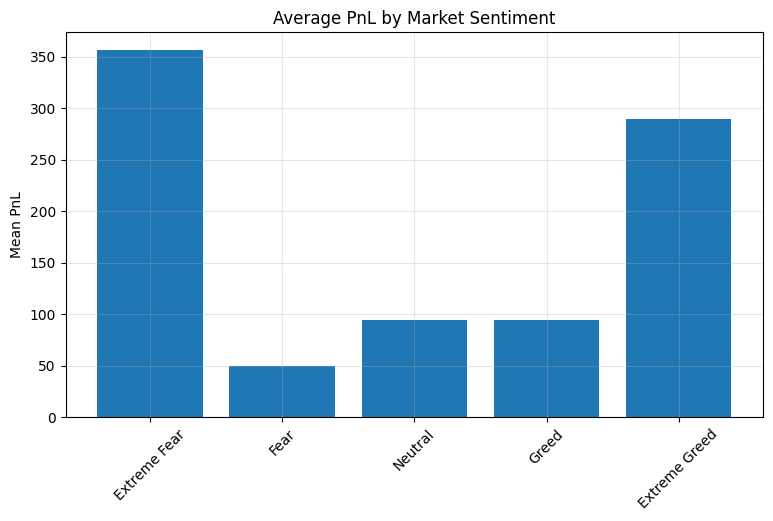

In [15]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df_analysis = df.copy()

# Create sentiment buckets from value (0–100)
df_analysis['sentiment_bucket'] = pd.cut(
    df_analysis['value'],
    bins=[-1,20,40,60,80,101],
    labels=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed']
)

# PnL distribution per sentiment
sent_pnl = df_analysis.groupby('sentiment_bucket')['Closed PnL'].agg(['count','mean','median','std']).reset_index()

print("\n=== PnL by Sentiment ===")
display(sent_pnl)

plt.figure(figsize=(9,5))
plt.bar(sent_pnl['sentiment_bucket'], sent_pnl['mean'])
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Mean PnL")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Trader profitability peaks at sentiment extremes, highest during Extreme Fear (contrarian opportunity) and next during Extreme Greed (momentum), while moderate sentiment phases yield weaker returns.

/tmp/ipython-input-3722484093.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_sent = df_analysis.groupby('sentiment_bucket')['Closed PnL'].describe()


,count,mean,std,min,25%,50%,75%,max
sentiment_bucket,,,,,,,,
Extreme Fear,1720.0,356.064801,3289.986180,-5843.040000,0.0,0.000000,66.031395,115287.00000
Fear,20064.0,49.788467,706.232049,-29370.119800,0.0,0.000000,3.126635,47883.62595
Neutral,22829.0,94.617094,1412.172500,-19841.240140,0.0,0.000000,11.513280,135329.09010
Greed,22582.0,93.974277,1421.723224,-117990.104100,0.0,0.000000,13.952250,71535.71674
Extreme Greed,2616.0,289.491066,2033.367287,-4948.586829,0.0,6.973174,67.403435,29999.90625


<Figure size 1000x500 with 0 Axes>

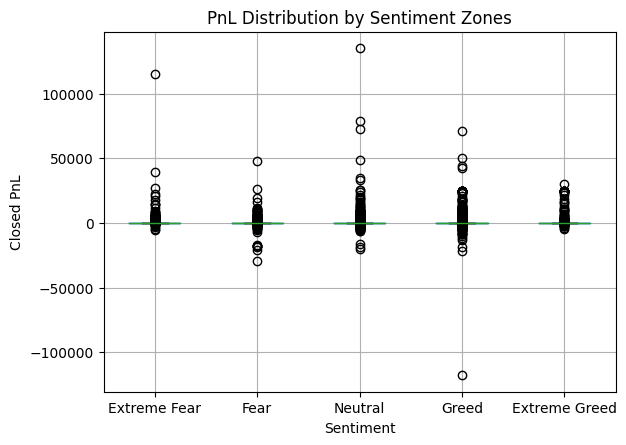

In [16]:
risk_sent = df_analysis.groupby('sentiment_bucket')['Closed PnL'].describe()
display(HTML("<h3>Risk Analysis (PnL Distribution by Sentiment)</h3>"))
display(risk_sent)

# Boxplot for deeper insight
plt.figure(figsize=(10,5))
df_analysis.boxplot(column='Closed PnL', by='sentiment_bucket')
plt.title("PnL Distribution by Sentiment Zones")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.show()

Extreme sentiment phases create the biggest winners and the biggest losers, showing that both Extreme Fear and Extreme Greed amplify volatility, making these periods high-risk, high-reward trading environments.


=== Buy vs Sell Performance by Sentiment ===


/tmp/ipython-input-312459159.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  side_sent = df_analysis.groupby(['Side','sentiment_bucket'])['Closed PnL'].agg(['count','mean','median']).reset_index()


,Side,sentiment_bucket,count,mean,median
0,Buy,Extreme Fear,1323,461.974931,0.000000
1,Buy,Fear,10947,63.125778,0.000000
2,Buy,Neutral,11523,112.261426,0.000000
3,Buy,Greed,10245,50.480713,0.000000
4,Buy,Extreme Greed,847,17.534799,0.000000
5,Sell,Extreme Fear,397,3.119956,0.000000
6,Sell,Fear,9117,33.774037,0.997248
7,Sell,Neutral,11306,76.634108,0.138740
8,Sell,Greed,12337,130.092586,0.078058
9,Sell,Extreme Greed,1769,419.704158,12.160400


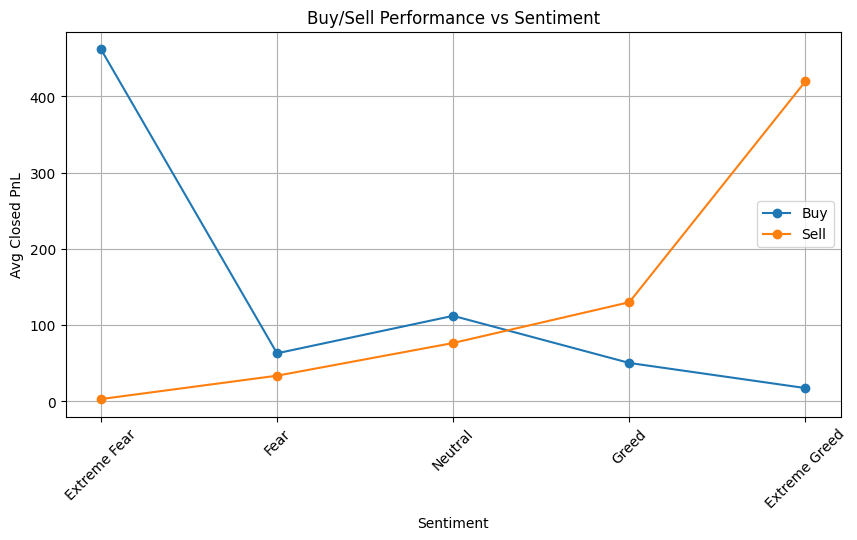

In [17]:
df_analysis['Side'] = df_analysis['Side'].astype(str).str.title()

side_sent = df_analysis.groupby(['Side','sentiment_bucket'])['Closed PnL'].agg(['count','mean','median']).reset_index()
print("\n=== Buy vs Sell Performance by Sentiment ===")
display(side_sent)

plt.figure(figsize=(10,5))
for side in side_sent['Side'].unique():
    temp = side_sent[side_sent['Side'] == side]
    plt.plot(temp['sentiment_bucket'], temp['mean'], marker='o', label=side)

plt.title("Buy/Sell Performance vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg Closed PnL")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

Buy trades perform best during Extreme Fear, while sell trades outperform strongly as sentiment shifts toward Extreme Greed, indicating opposite optimal strategies at sentiment extremes.

/tmp/ipython-input-403962143.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Coin','sentiment_bucket'])['Closed PnL']


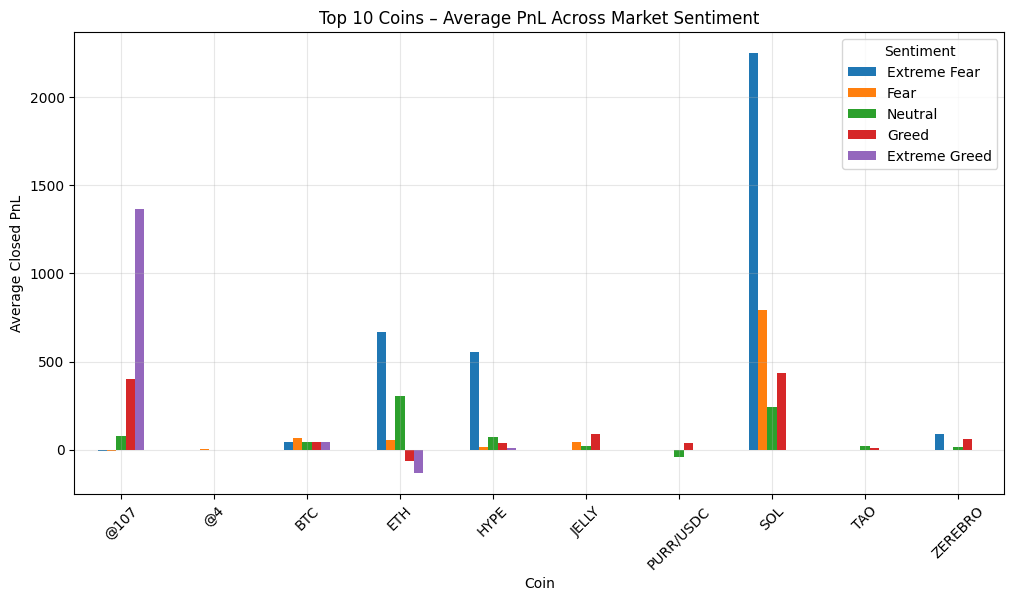

In [25]:
# Top 10 coins by trade count
top_coins = df_analysis['Coin'].value_counts().head(10).index

filtered = df_analysis[df_analysis['Coin'].isin(top_coins)]

coin_sent_pnl = (
    filtered
    .groupby(['Coin','sentiment_bucket'])['Closed PnL']
    .mean()
    .reset_index()
)

pivot_coin = coin_sent_pnl.pivot(
    index='Coin',
    columns='sentiment_bucket',
    values='Closed PnL'
)

pivot_coin
pivot_coin.plot(kind='bar', figsize=(12,6))
plt.title("Top 10 Coins – Average PnL Across Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.xlabel("Coin")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title="Sentiment")
plt.show()

The top traded coins show strong but uneven sensitivity to market sentiment, with some generating outsized profits during Extreme Fear or Extreme Greed, while others remain relatively stable, indicating that sentiment-driven strategies are more effective when selectively applied to sentiment-sensitive assets rather than the entire market.


=== PnL by Hour of Day ===


,hour,count,mean,median
0,0,3979,64.919008,0.000000
1,1,4441,78.220433,0.000000
2,2,4365,38.383383,0.000000
3,3,4897,99.445485,0.000000
4,4,4339,96.219698,0.000000
5,5,4056,61.046992,0.000000
6,6,2508,56.006840,0.000000
7,7,3819,146.682548,0.000000
8,8,2367,44.491393,0.000000
9,9,1550,92.265857,0.047765


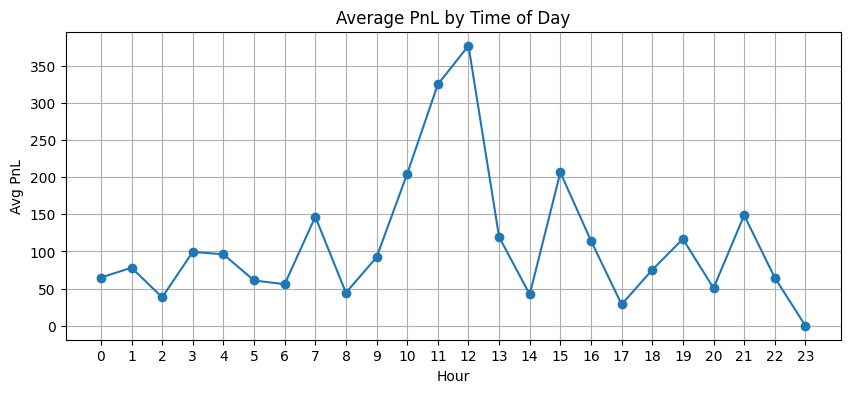

In [19]:
df_analysis['hour'] = df_analysis['trade_dt'].dt.hour

hour_pnl = df_analysis.groupby('hour')['Closed PnL'].agg(['count','mean','median']).reset_index()
print("\n=== PnL by Hour of Day ===")
display(hour_pnl)

plt.figure(figsize=(10,4))
plt.plot(hour_pnl['hour'], hour_pnl['mean'], marker='o')
plt.title("Average PnL by Time of Day")
plt.xlabel("Hour")
plt.ylabel("Avg PnL")
plt.grid(True)
plt.xticks(range(24))
plt.show()

Trader profitability varies by time of day, peaking around mid-day hours (≈11–13), indicating that trades executed during these high-liquidity periods tend to deliver better average returns than late-night or low-activity hours.


=== PnL by Sentiment Lag ===


,lag_group,count,mean,median
0,Same Day,39051,90.219142,0.0
1,±1 Day,30760,101.680394,0.0


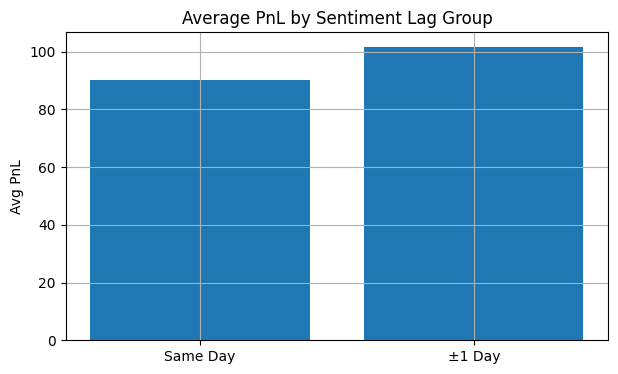

In [20]:
def lag_cat(x):
    if x == 0: return 'Same Day'
    if abs(x) == 1: return '±1 Day'
    if abs(x) == 2: return '±2 Days'
    return 'Older'

df_analysis['lag_group'] = df_analysis['date_diff_days'].apply(lag_cat)

lag_pnl = df_analysis.groupby('lag_group')['Closed PnL'].agg(['count','mean','median']).reset_index()
print("\n=== PnL by Sentiment Lag ===")
display(lag_pnl)

plt.figure(figsize=(7,4))
plt.bar(lag_pnl['lag_group'], lag_pnl['mean'])
plt.title("Average PnL by Sentiment Lag Group")
plt.ylabel("Avg PnL")
plt.grid(True)
plt.show()

Trades aligned with sentiment from the same or previous day perform better than delayed reactions, indicating that market sentiment impacts trader performance most strongly within a short (≤1 day) window.

In [21]:
corr = df_analysis['value'].corr(df_analysis['Closed PnL'])
print("\nCorrelation between Sentiment Index (0–100) and Closed PnL:", round(corr,4))


Correlation between Sentiment Index (0–100) and Closed PnL: 0.0123


In [22]:
vol = df_analysis.groupby('sentiment_bucket')['Closed PnL'].std().reset_index()
print("\nVolatility of PnL by Sentiment Zone:")
display(vol)


Volatility of PnL by Sentiment Zone:


/tmp/ipython-input-1406476142.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol = df_analysis.groupby('sentiment_bucket')['Closed PnL'].std().reset_index()


,sentiment_bucket,Closed PnL
0,Extreme Fear,3289.986180
1,Fear,706.232049
2,Neutral,1412.172500
3,Greed,1421.723224
4,Extreme Greed,2033.367287



=== Win Rate by Sentiment ===


/tmp/ipython-input-3720904516.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winrate = df_analysis.groupby('sentiment_bucket')['win'].mean().reset_index()


,sentiment_bucket,win_rate
0,Extreme Fear,0.384302
1,Fear,0.415371
2,Neutral,0.422270
3,Greed,0.448765
4,Extreme Greed,0.579511


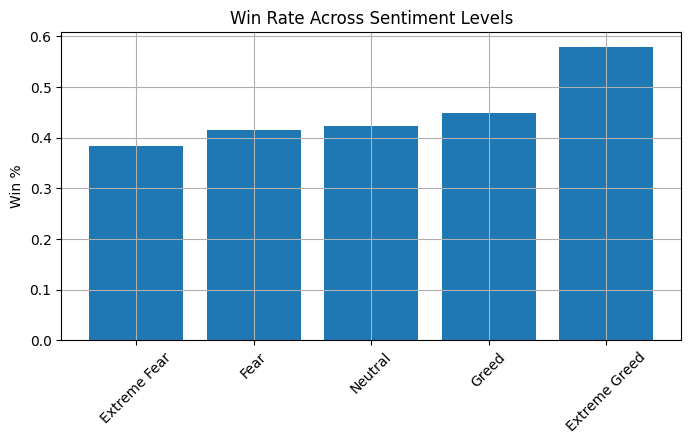

In [23]:
df_analysis['win'] = df_analysis['Closed PnL'] > 0

winrate = df_analysis.groupby('sentiment_bucket')['win'].mean().reset_index()
winrate.columns = ['sentiment_bucket','win_rate']

print("\n=== Win Rate by Sentiment ===")
display(winrate)

plt.figure(figsize=(8,4))
plt.bar(winrate['sentiment_bucket'], winrate['win_rate'])
plt.title("Win Rate Across Sentiment Levels")
plt.ylabel("Win %")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Win rates steadily increase as market sentiment shifts from fear to greed, peaking during Extreme Greed, indicating a higher probability of profitable trades in strongly bullish market conditions even though average returns may be higher during fear-driven extremes.

**Trader Profiling / Smart Money analysis**

In [26]:
# Make a working copy
smart_df = df.copy()

# Clean up key columns
smart_df['classification'] = smart_df['classification'].astype(str).str.strip().str.title()
smart_df['Direction'] = smart_df['Direction'].astype(str).str.strip().str.title()
smart_df['Side'] = smart_df['Side'].astype(str).str.strip().str.title()

# Ensure numeric
for col in ['Closed PnL', 'Size USD']:
    if col in smart_df.columns:
        smart_df[col] = pd.to_numeric(smart_df[col], errors='coerce')

# set a consistent sentiment order
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
smart_df['classification'] = pd.Categorical(
    smart_df['classification'],
    categories=sentiment_order,
    ordered=True
)

TRADER PROFILING

Top 10 most profitable accounts:


,Account,Total_Closed_PnL
11,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2.143383e+06
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06
5,0x513b8629fe877bb581bf244e326a047b249c4ff1,8.404226e+05
3,0x430f09841d65beb3f27765503d0f850b8bce7713,4.165419e+05
7,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,4.030115e+05
8,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3.790954e+05
4,0x4f93fead39b70a1824f981a54d4e55b278e9f760,3.089759e+05
2,0x420ab45e0bd8863569a5efbb9c05d91f40624641,1.995056e+05
6,0x6d6a4b953f202f8df5bed40692e7fd865318264a,1.087312e+05
12,0xbaaaf6571ab7d571043ff1e313a9609a10637864,6.969561e+04


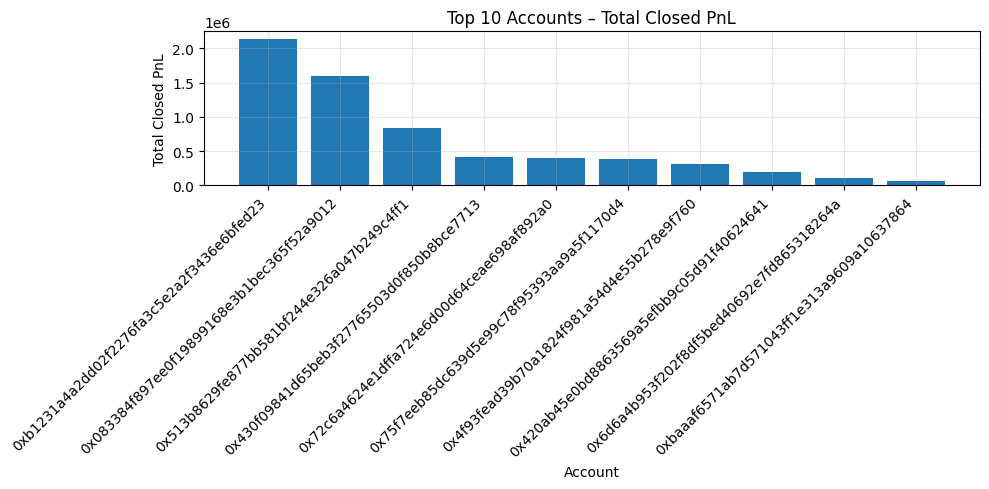


Smart Money trades: 60057 rows (out of 69811)


In [27]:
# Total Closed PnL per account
account_pnl = (
    smart_df
    .groupby('Account', as_index=False)['Closed PnL']
    .sum()
    .rename(columns={'Closed PnL': 'Total_Closed_PnL'})
)

# Sort & take top 10 profitable accounts
top_accounts = (
    account_pnl
    .sort_values('Total_Closed_PnL', ascending=False)
    .head(10)
)

print("Top 10 most profitable accounts:")
display(top_accounts)

# Bar chart of top accounts
plt.figure(figsize=(10,5))
plt.bar(top_accounts['Account'].astype(str), top_accounts['Total_Closed_PnL'])
plt.title('Top 10 Accounts – Total Closed PnL')
plt.xlabel('Account')
plt.ylabel('Total Closed PnL')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Filter dataset to Smart Money cohort
smart_money = smart_df[smart_df['Account'].isin(top_accounts['Account'])]
print(f"\nSmart Money trades: {len(smart_money)} rows (out of {len(smart_df)})")

Trading profitability is highly concentrated among a small subset of accounts, with the top few traders generating a disproportionate share of total Closed PnL, validating their classification as “Smart Money” and highlighting strong skill or strategy advantages over the broader trader population.

 SMART MONEY vs MARKET SENTIMENT


Smart Money – Volume & PnL by Sentiment:


/tmp/ipython-input-2208008012.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('classification', as_index=False)


,classification,Total_Size_USD,Total_Closed_PnL,Trade_Count
0,Extreme Fear,2.429893e+07,7.198017e+05,3307
1,Fear,2.531366e+08,1.485350e+06,19122
2,Neutral,1.176634e+08,1.144625e+06,10861
3,Greed,2.513876e+08,1.426239e+06,17113
4,Extreme Greed,7.643020e+07,1.693576e+06,9654


/tmp/ipython-input-2208008012.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['classification', 'Side'])['Size USD']


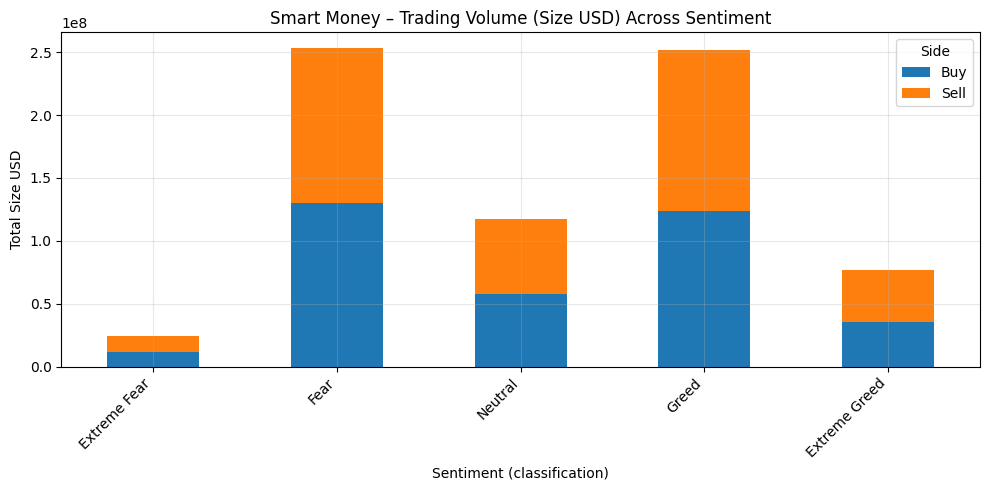

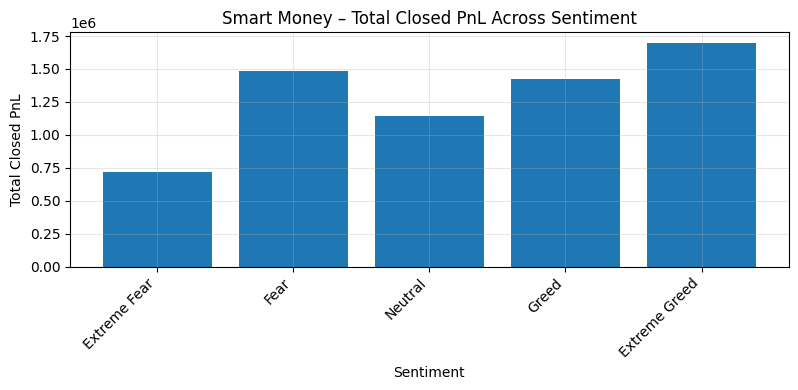

In [28]:
# Aggregate by sentiment for Smart Money
sm_sent = (
    smart_money
    .groupby('classification', as_index=False)
    .agg(
        Total_Size_USD=('Size USD', 'sum'),
        Total_Closed_PnL=('Closed PnL', 'sum'),
        Trade_Count=('Closed PnL', 'count')
    )
    .sort_values('classification')
)

print("\nSmart Money – Volume & PnL by Sentiment:")
display(sm_sent)

# Stacked bar: volume split by Side (to make "stacked" meaningful)
vol_by_side = (
    smart_money
    .groupby(['classification', 'Side'])['Size USD']
    .sum()
    .unstack(fill_value=0)
    .reindex(sentiment_order)
)

plt.figure(figsize=(10,5))
vol_by_side.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Smart Money – Trading Volume (Size USD) Across Sentiment')
plt.xlabel('Sentiment (classification)')
plt.ylabel('Total Size USD')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title='Side')
plt.tight_layout()
plt.show()

# Optional: separate bar for Total PnL by sentiment
plt.figure(figsize=(8,4))
plt.bar(sm_sent['classification'].astype(str), sm_sent['Total_Closed_PnL'])
plt.title('Smart Money – Total Closed PnL Across Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Total Closed PnL')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Smart Money allocates the largest trading volumes during Fear and Greed phases, especially increasing activity as sentiment strengthens, indicating a predominantly trend-following approach that scales position size in high-conviction market conditions rather than aggressively trading during periods of extreme panic.

DIRECTIONAL STRATEGY ANALYSIS


Smart Money – Avg Closed PnL by Sentiment and Direction:


/tmp/ipython-input-814201321.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['classification', 'Direction'])['Closed PnL']


Direction,Auto-Deleveraging,Buy,Close Long,Close Short,Long > Short,Open Long,Open Short,Sell,Short > Long,Spot Dust Conversion
classification,,,,,,,,,,
Extreme Fear,NaN,0.0,35.790890,825.492051,NaN,0.0,0.0,-29.075178,NaN,NaN
Fear,NaN,0.0,59.802025,464.144352,218.526123,0.0,0.0,25.941922,-2158.585417,0.0
Neutral,NaN,0.0,121.684425,286.158264,-0.006476,0.0,0.0,277.058723,-275.191204,0.0
Greed,7184.807003,0.0,115.219972,207.511701,106.153621,0.0,0.0,361.421933,158.754740,0.0
Extreme Greed,NaN,0.0,87.314680,-24.897742,416.833220,0.0,0.0,1672.169431,NaN,0.0


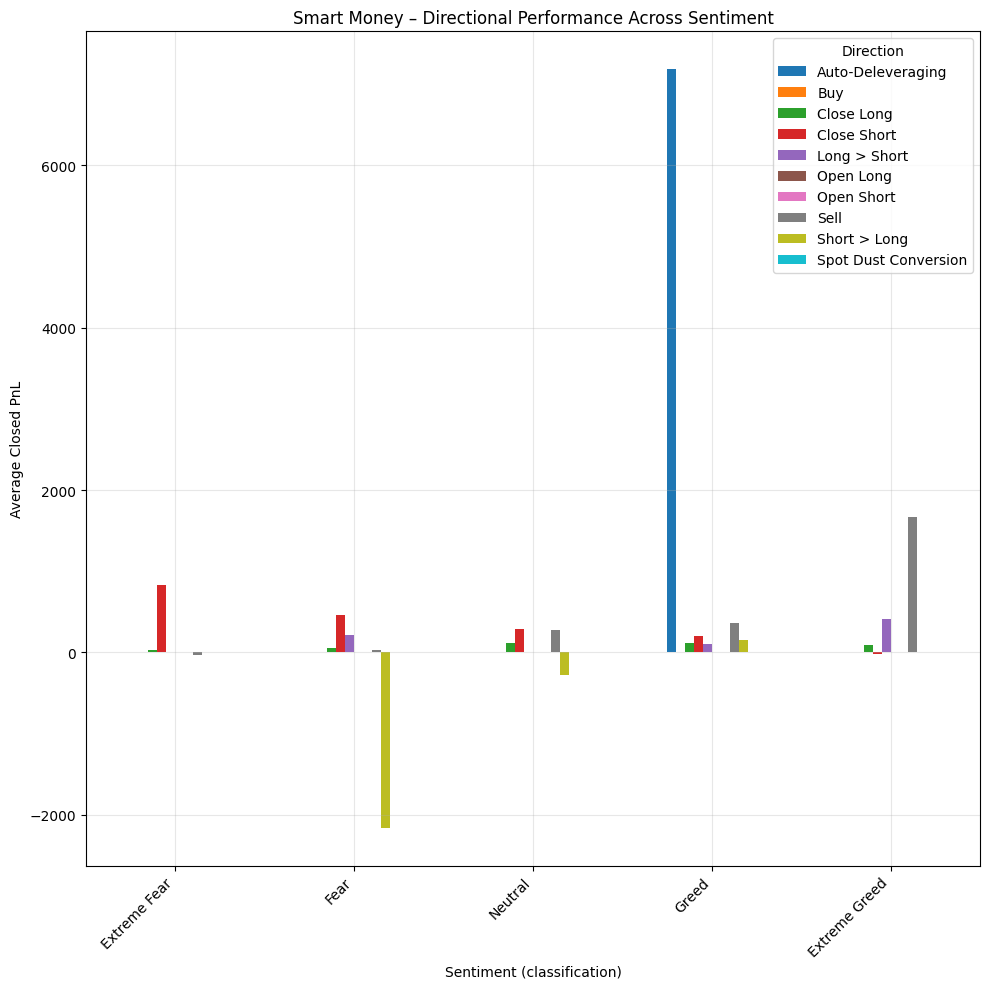

In [30]:
# Average PnL by sentiment and direction
dir_pnl = (
    smart_money
    .groupby(['classification', 'Direction'])['Closed PnL']
    .mean()
    .unstack(fill_value=0)
    .reindex(sentiment_order)
)

print("\nSmart Money – Avg Closed PnL by Sentiment and Direction:")
display(dir_pnl)

# Grouped bar chart
plt.figure(figsize=(10,10))
dir_pnl.plot(kind='bar', ax=plt.gca())
plt.title('Smart Money – Directional Performance Across Sentiment')
plt.xlabel('Sentiment (classification)')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title='Direction')
plt.tight_layout()
plt.show()

Smart Money profitability is highly strategy-dependent, with closing positions (especially Close Short during Extreme Fear and Sell/Close Long during Extreme Greed) driving the strongest gains, indicating disciplined profit-taking and sentiment-aware position unwinding rather than indiscriminate buying or selling.